In [4]:
import os
import json
import torch
import numpy as np
from PIL import Image
from collections import Counter

from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    CLIPTokenizer,
    CLIPTextModel,
    Dinov2Model,
)
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [5]:
IMG_DIR  = "/pfs/data6/home/st/st_us-053000/st_st195720/Object_Segmentation_NFL/Team_masks2/images"
MASK_DIR = "/pfs/data6/home/st/st_us-053000/st_st195720/Object_Segmentation_NFL/Team_masks2/all_masks"

TRAIN_JSON = "/pfs/data6/home/st/st_us-053000/st_st195720/Object_Segmentation_NFL/train.json"
VAL_JSON   = "/pfs/data6/home/st/st_us-053000/st_st195720/Object_Segmentation_NFL/val.json"
TEST_JSON  = "/pfs/data6/home/st/st_us-053000/st_st195720/Object_Segmentation_NFL/test.json"

COCO_JSON  = "/pfs/data6/home/st/st_us-053000/st_st195720/Object_Segmentation_NFL/_annotations_additional_info.coco.json"


In [6]:
with open(COCO_JSON) as f:
    coco = json.load(f)

# Map category id → name
cat_id_to_name = {c["id"]: c["name"] for c in coco["categories"]}

# We only care about offensive players
OFFENSE_ROLES = {"qb", "oline", "skill"}

# Group annotations by image_id
ann_by_image = {}

for ann in coco["annotations"]:
    role = cat_id_to_name.get(ann["category_id"])
    if role in OFFENSE_ROLES:
        ann_by_image.setdefault(ann["image_id"], []).append(ann)


In [7]:

def load_offense_mask(mask_path):
    mask_rgb = Image.open(mask_path).convert("RGB")
    mask_np = np.array(mask_rgb)

    # Blue channel = offense
    offense = (
        (mask_np[:, :, 2] > 150) &
        (mask_np[:, :, 0] < 100) &
        (mask_np[:, :, 1] < 100)
    )

    # Convert to white-on-black image for DINO
    img = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    img[offense] = [255, 255, 255]

    return Image.fromarray(img)


In [8]:
def pairwise_distances(vals):
    if len(vals) < 2:
        return 0.0
    return np.mean([
        abs(vals[i] - vals[j])
        for i in range(len(vals))
        for j in range(i+1, len(vals))
    ])


def bin_value(x, bins, labels):
    for b, l in zip(bins, labels):
        if x < b:
            return l
    return labels[-1]


In [9]:
def geometry_to_prompt(anns, w, h):
    qb = None
    oline_x = []
    skill = []


    for ann in anns:
        role = cat_id_to_name[ann["category_id"]]
        x, y, bw, bh = ann["bbox"]

        cx = (x + bw / 2) / w
        cy = (y + bh / 2) / h

        if role == "qb":
            qb = (cx, cy)
        elif role == "oline":
            oline_x.append(cx)
        elif role == "skill":
            skill.append((cx, cy))

    if qb is None or len(oline_x) == 0:
        return None

    qb_x, qb_y = qb
    oline_center = np.mean(oline_x)


    qb_align = "under center" if qb_y < 0.25 else "shotgun"
    qb_depth = (
        "very shallow" if qb_y < 0.20 else
        "shallow" if qb_y < 0.35 else
        "deep"
    )


    left, right, backfield = [], [], []
    left_x, right_x = [], []

    for sx, sy in skill:
        if sy > qb_y:
            # backfield
            if sx < qb_x - 0.05:
                backfield.append("RB left")
            elif sx > qb_x + 0.05:
                backfield.append("RB right")
            else:
                backfield.append("RB behind quarterback")
        else:
            if sx < oline_center:
                left.append("WR")
                left_x.append(sx)
            else:
                right.append("WR")
                right_x.append(sx)


    def spacing_desc(xs):
        if len(xs) < 2:
            return "tight"
        span = max(xs) - min(xs)
        return "tight" if span < 0.15 else "spaced"


    def side_text(players, xs):
        if not players:
            return "none"
        return (
            f"{', '.join(players)} "
            f"({len(players)} players, {spacing_desc(xs)})"
        )

    def backfield_text(players):
        if not players:
            return "none"
        return f"{', '.join(players)} ({len(players)} players)"

    prompt = (
        "Offensive formation description.\n"
        f"Quarterback: {qb_align}, {qb_depth}.\n"
        f"Left of offensive line: {side_text(left, left_x)}.\n"
        f"Right of offensive line: {side_text(right, right_x)}.\n"
        f"Backfield: {backfield_text(backfield)}."
    )

    return prompt


In [10]:
def count_formations(split_json):
    with open(split_json) as f:
        data = json.load(f)
    return Counter(
        img["attributes"]["formation"]
        for img in data["images"]
        if "formation" in img.get("attributes", {})
    )

counts = count_formations(TRAIN_JSON)
VALID_CLASSES = sorted([k for k,v in counts.items() if v >= 5])

label_to_idx = {c:i for i,c in enumerate(VALID_CLASSES)}
idx_to_label = {i:c for c,i in label_to_idx.items()}

print("Using classes:", VALID_CLASSES)


Using classes: ['ace-left', 'ace-right', 'bunch-left', 'bunch-right', 'double-tight', 'empty', 'heavy', 'i-formation', 'pro', 'shotgun', 'stacked', 'trey-left', 'trey-right', 'trips-left', 'trips-right', 'twins-left', 'twins-right']


In [11]:
class NFLMultimodalDataset(Dataset):
    def __init__(self, split_json):
        with open(split_json) as f:
            images = json.load(f)["images"]

        self.samples = []

        for img in images:
            formation = img.get("attributes", {}).get("formation")
            if formation not in label_to_idx:
                continue

            image_id = img["id"]
            if image_id not in ann_by_image:
                continue

            prompt = geometry_to_prompt(
                ann_by_image[image_id],
                img["width"],
                img["height"]
            )
            if prompt is None:
                continue

            mask_path = os.path.join(
                MASK_DIR, img["file_name"] + "_team_mask.png"
            )
            if not os.path.exists(mask_path):
                continue

            self.samples.append(
                (mask_path, prompt, label_to_idx[formation])
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, text, label = self.samples[idx]
        image = load_offense_mask(path)

        return image, text, torch.tensor(label)


In [12]:
def multimodal_collate(batch):
    imgs, texts, labels = zip(*batch)
    return list(imgs), list(texts), torch.stack(labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dino = Dinov2Model.from_pretrained("facebook/dinov2-base").to(device)
dino.eval()
for name, param in dino.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True


tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text = CLIPTextModel.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(device)
clip_text.eval()
for name, param in clip_text.named_parameters():
    if "encoder.layers.10" in name or "encoder.layers.11" in name:
        param.requires_grad = True


In [13]:
class DinoCLIPFusion(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(768 + 512, 768),
            nn.ReLU(),
            nn.BatchNorm1d(768),
            nn.Dropout(0.4),

            nn.Linear(768, 384),
            nn.ReLU(),
            nn.BatchNorm1d(384),
            nn.Dropout(0.3),

            nn.Linear(384, num_classes)
        )

    def forward(self, img_emb, txt_emb):
        x = torch.cat([img_emb, txt_emb], dim=1)
        return self.fc(x)


In [14]:
train_ds = NFLMultimodalDataset(TRAIN_JSON)
val_ds   = NFLMultimodalDataset(VAL_JSON)
test_ds  = NFLMultimodalDataset(TEST_JSON)

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=True,
    collate_fn=multimodal_collate
)
val_loader = DataLoader(
    val_ds, batch_size=4, collate_fn=multimodal_collate
)
test_loader = DataLoader(
    test_ds, batch_size=4, collate_fn=multimodal_collate
)

model = DinoCLIPFusion(len(VALID_CLASSES)).to(device)
optimizer = torch.optim.AdamW(
    [

        {
            "params": model.parameters(),
            "lr": 1e-4,
        },

        {
            "params": [
                p for p in dino.parameters() if p.requires_grad
            ],
            "lr": 1e-5,
        },
    ],
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss()


In [15]:
@torch.no_grad()
def encode_images(images):
    imgs = torch.stack([
        torch.from_numpy(np.array(im.resize((224,224)))).permute(2,0,1)
        for im in images
    ]).float().to(device) / 255.0

    feats = dino(pixel_values=imgs).last_hidden_state[:,1:,:]
    return feats.mean(dim=1)  # [B,768]


@torch.no_grad()
def encode_texts(texts):
    tokens = tokenizer(
        texts, padding=True, truncation=True,
        return_tensors="pt"
    ).to(device)
    return clip_text(**tokens).last_hidden_state[:,0]


In [16]:
def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    preds, gts = [], []

    for imgs, texts, labels in loader:
        labels = labels.to(device)

        with torch.no_grad():
            img_emb = encode_images(imgs)
            txt_emb = encode_texts(texts)

        logits = model(img_emb, txt_emb)
        loss = criterion(logits, labels)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        preds.extend(logits.argmax(1).cpu().tolist())
        gts.extend(labels.cpu().tolist())

    return accuracy_score(gts, preds)


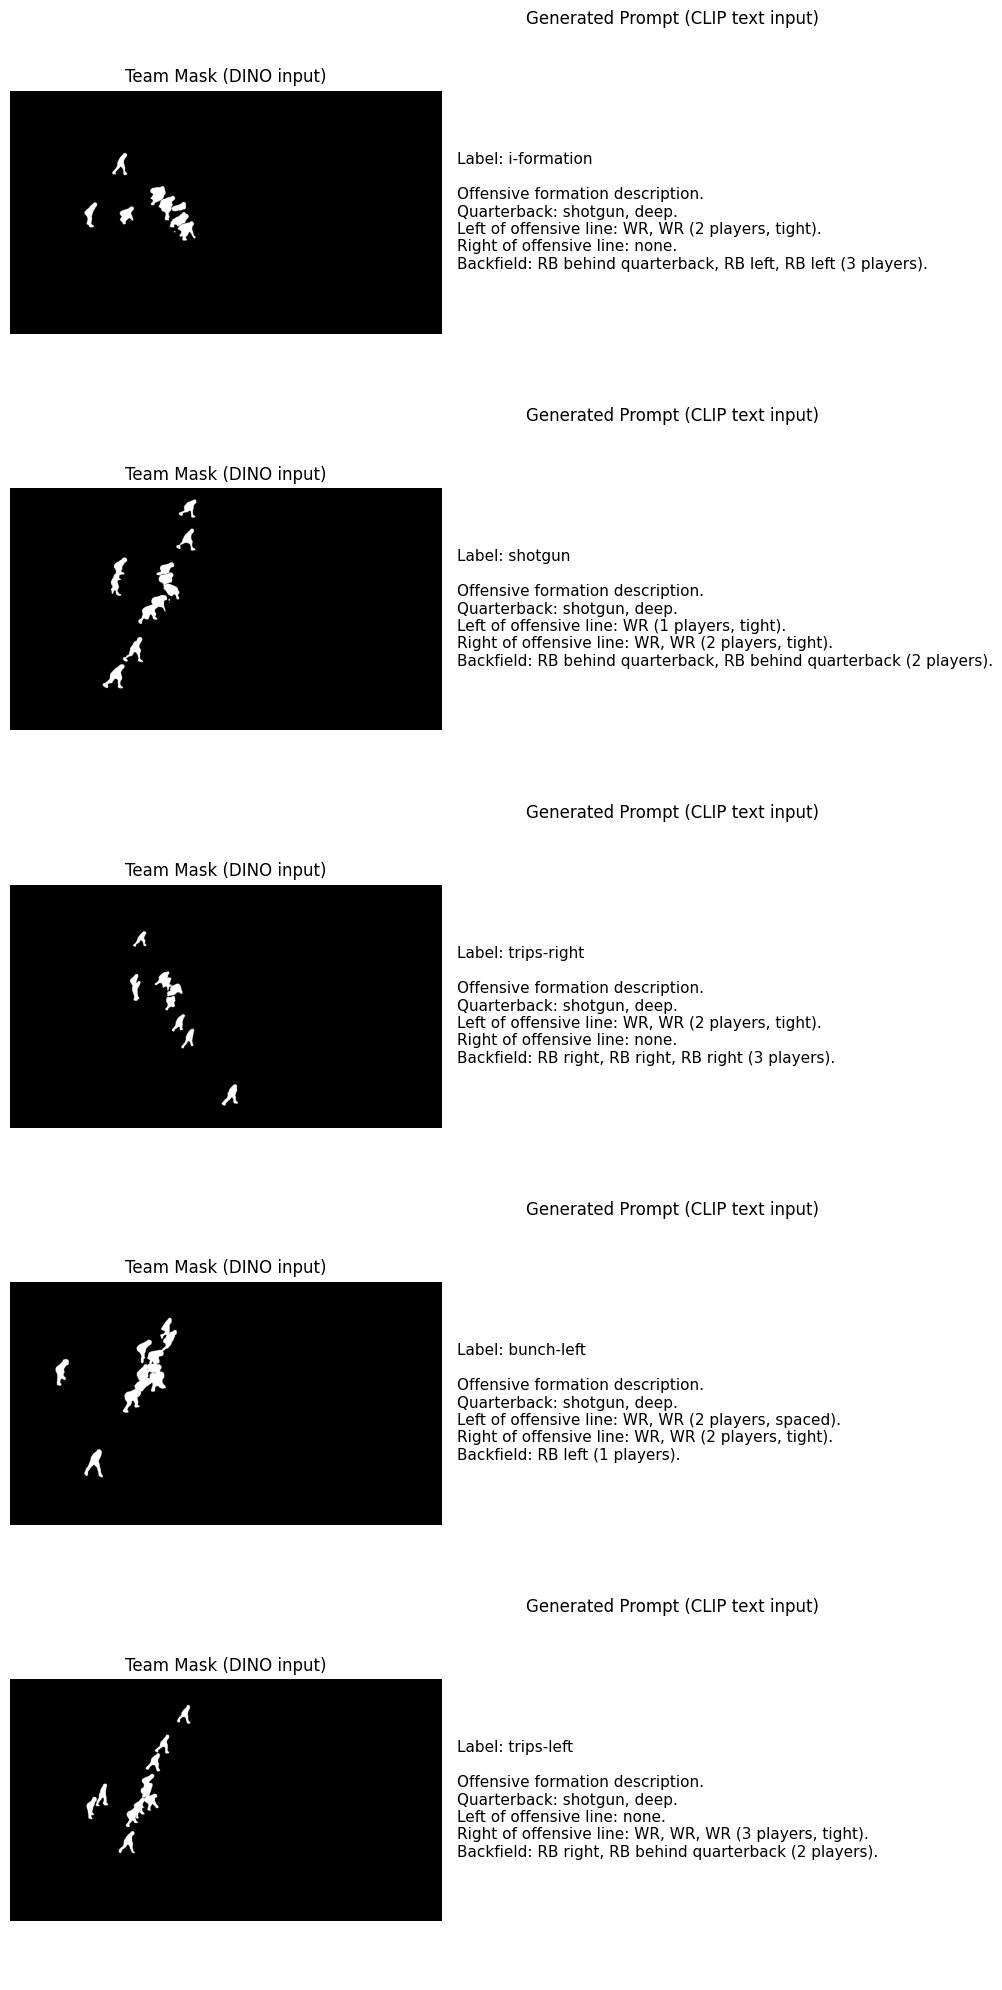

In [19]:
import random
def visualize_samples(dataset, idxs=None, n=5):
    """
    Visualize mask images + prompts + labels from dataset.
    """
    if idxs is None:
        idxs = random.sample(range(len(dataset)), n)

    fig, axes = plt.subplots(len(idxs), 2, figsize=(10, 4 * len(idxs)))

    if len(idxs) == 1:
        axes = [axes]  

    for row, idx in enumerate(idxs):
        image, text, label = dataset[idx]


        axes[row][0].imshow(image)
        axes[row][0].axis("off")
        axes[row][0].set_title("Team Mask (DINO input)")

        axes[row][1].axis("off")
        axes[row][1].text(
            0.0, 0.5,
            f"Label: {idx_to_label[label.item()]}\n\n{text}",
            fontsize=11,
            va="center",
            wrap=True
        )
        axes[row][1].set_title("Generated Prompt (CLIP text input)")

    plt.tight_layout()
    plt.show()
visualize_samples(train_ds, n=5)

In [2]:
for epoch in range(35):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader)
    print(f"Epoch {epoch:02d} | Train {tr:.3f} | Val {va:.3f}")
test_acc = run_epoch(test_loader)
print("Test accuracy:", test_acc)


NameError: name 'run_epoch' is not defined

In [1]:
test_acc = run_epoch(test_loader)
print("Test accuracy:", test_acc)
import random

NameError: name 'run_epoch' is not defined